## Homework 1 - Yeehaw! Data Wrangling!
### Hubert Wang

**COLLABORATED WITH:_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _**

***
***
***

**Submit a PDF export of your notebook (100% PENALTY)** 

***
***
***

#### Table of Contents
- [Overview](#Overview)
- [[10 Points] Preliminaries](#[10-Points]-Preliminaries)
- [ACS](#ACS)
    - [[15 Points] Prep](#[15-Points]-Prep)
    - [[5 Points] Creating Keys](#[5-Points]-Creating-Keys)
    - [[15 Points] Grouped Features](#[15-Points]-Grouped-Features)
    - [[10 Points] Individual Features](#[10-Points]-Individual-Features)
    - [[5 Points] Labels](#[5-Points]-Labels)
- [[10 Points] FHFA](#[10-Points]-FHFA)
- [[25 Points] Transformations](#[25-Points]-Transformations)
- [[5 Points] Pickling](#[5-Points]-Pickling)

# Overview

**DOWNLOAD ALL DATA INTO THE SAME FOLDER**

We will be primarily using data from the 2016 American Community Survey (ACS) sourced from https://ipums.org/. 
You will need to **create a free account** to access the data.

ACS Steps:

* On the USA IPUMS page either click the Get Data button or the Select Data tab
* Click change samples. Ensure only ACS 2016 is selected (You can click the Default sample from each year button to unselect the preselected)
* Select variables
    - STATEFIP, COUNTYFIP, PUMA, DENSITY, NCHILD, SEX, AGE, RACE, HISPAN, EDUC, EMPSTAT, OCC2010, IND1990, UHRSWORK, INCWAGE
* View cart
* For reducing the size of the extract, **unselect** the following preselected variables (we need the others)
    - YEAR, SAMPLE, CBSERIAL, HHWT, CLUSTER, STRATA
* CREATE DATA EXTRACT
* DATA FORMAT > Change > Comma delimited (.csv) > SUBMIT
* Provide a description of the extract like: "AML in Econ homework data"
* SUBMIT EXTRACT

**SUPER IMPORTANT** Each variable (continuous or categorical) has an associated code to it. For an example of a codebook you will need, click on the EDUC variable, go to the codes tab, and select the Detailed codes (44 categories) *and* Case-count view.

To extract:
- **Windows Users**: Use 7zip to extract (like I do) https://www.7-zip.org/download.html
- **MAC Users**: In your terminal, navigate to the location of your file. Type `gunzip usa_000XX.csv.gz`

Because surveys tend to ask a let of yes or no questions, they primarily consist of dummy variables. 
We are going to add to our list of continuous variables by merging county-level housing data from the Federal Housing Finance Agency (FHFA) https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx.

FHFA Steps:

* Download the counties developmental index
* Open it and notice the preamble and where the data begins

***

Because we will be demonstrating different techniques for different types of labels in this class, we will create three different types of label that can be interchangeably used as features. 

* Labels
    - wage (continuous)
    - full-time dummy (binary)
    - degree $\in \{\leq$ HS, some college, $\geq$ BA$\}$
- Features
    * public use micro area (puma) unemployment rate
    * percent of workers in an occupation with a bachelor's degree
    * average industry wages
    * experience = age - years of schooling - 6
    * female indicator
    * any kids at home indicator
    * black indicator
    * hispanic indicator
    * 2000 based house price index

# [10 Points] Preliminaries

- **[5 points]** Import `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn` and `os`.
- **[1 point]** Change your working directory to where your data are saved.
- **[2 points]** List the files in the directory
- **[2 points]** Set up `seaborn` parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('C:/Users/hubst/ECON_490/Homework 1')
print(os.listdir())

sns.set(rc = {'axes.titlesize': 24,
             'axes.labelsize': 15,
             'xtick.labelsize': 10,
             'ytick.labelsize': 10,
             'figure.figsize': (10, 5)})

['.ipynb_checkpoints', 'HPI_AT_BDL_county.xlsx', 'HW1 Firstname Lastname.ipynb', 'HW1 Hubert Wang.ipynb', 'hw_data.pkl', 'usa_00001.csv']


*******
# ACS
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)


## [15 Points] Prep
- **[1 point]** Load in the data as an object named `acs`

In [2]:
acs = pd.read_csv('usa_00001.csv')

- **[2 point]** Holding down shift is annoying. Make all of the variables lowercase.

In [3]:
acs = acs.rename(columns = str.lower)

In [4]:
acs['county'] = acs.statefip*1000 + acs.countyfip
print(len(acs['county'].unique()))
acs['puma_code'] = acs.statefip*100000 + acs.puma
print(len(acs['puma_code'].unique()))

478
2351


Filter the data set such that:
* **[2 points]** individuals are not in group quarters
* **[2 points]** individuals are working age $\in [16, 65)$
* **[2 points]** there are no military or unemployed with no worth experience in the last five years occupations
* **[2 points]** there are no N/A, military or last worked 1984 or earlier industries
* **[2 points]** there are no N/A education values (*hint: EDUCD*)

In [5]:
# not in group quarters

acs = acs[acs['gq'] != 3]
acs = acs[acs['gq'] != 4]
acs = acs[acs['gq'] != 5]

# working age

acs = acs[acs['age'] >= 16]
acs = acs[acs['age'] < 65]

# no military occ

acs = acs[acs['occ2010'] != 9800]
acs = acs[acs['occ2010'] != 9810]
acs = acs[acs['occ2010'] != 9820]
acs = acs[acs['occ2010'] != 9830]

# no unemployed occ

acs = acs[acs['occ2010'] != 9920]

# no n/a ind

acs = acs[acs['ind1990'] != 0]

# no military ind

acs = acs[acs['ind1990'] != 940]
acs = acs[acs['ind1990'] != 941]
acs = acs[acs['ind1990'] != 942]
acs = acs[acs['ind1990'] != 950]
acs = acs[acs['ind1990'] != 951]
acs = acs[acs['ind1990'] != 952]
acs = acs[acs['ind1990'] != 960]

# no last worked 1984 ind

acs = acs[acs['ind1990'] != 992]

# no n/a educ

acs = acs[acs['educd'] != 0]
acs = acs[acs['educd'] != 1]

# no education

acs = acs[acs['educd'] != 2]

# missing values educ

acs = acs[acs['educd'] != 999]

* **[2 points]** drop the `gq` column

In [6]:
acs = acs.drop(columns = 'gq')

***
## [5 Points] Creating Keys
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

We need to create geographic and individual keys that will be used for linking.
Firstly, create the geographic keys:
* **[1 point]** `county` - county codes
* **[1 point]** `puma_code` - public use micro area code

*Hint: counties are fully identified by a 5 digit code. The first two are the state FIPS and the last three are the county FIPS. puma codes are a 7 digit code like counties. Think of a way using middle school level math to create these codes.*

*For example: Champaign county, IL and Cherokee county, AL both have county FIPS of 019, but IL has state FIPS of 17 and AL has state FIPS 1. This makes Champaign 17019 and Cherokee 1019*

In [7]:
acs['county'] = acs.statefip*1000 + acs.countyfip

acs['puma_code'] = acs.statefip*100000 + acs.puma

In [8]:
acs['county'] = acs.statefip*1000 + acs.countyfip
len(acs['county'].unique())

478

Individuals on the other hand are identified by their household `serial` number combined with the person number (`pernum`) in the household such that the last two digits are the person number. 
- **[1 point]** Using the same methodology as above, create a variable `id`

In [9]:
acs['id'] = acs.serial*100 + acs.pernum

Now
* **[2 points]** drop columns `countyfip`, `statefip`, `puma`, `pernum`, and `serial` in place

In [10]:
acs.drop(columns = ['countyfip', 'statefip', 'puma', 'pernum', 'serial'], inplace = True)

******
## [15 Points] Grouped Features
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

Next we will create the following grouped features: (1) unemployment rate grouped by PUMA, (2) percent with a bachelor's degree group by occupation, and (3) average wage grouped by industry. It should take three lines each (fewer if you are a better coder than I!):
1. create an empty temporary data frame
2. create a variable in the temporary data frame from a lambda function applied to the acs grouped by the group variable
3. join the temporary data frame to the ACS data by the group variable

Create the variables as described above
- **[5 points]** `puma_urate`
- **[5 points]** `occ_ba`
- **[5 points]** `ind_wage`

*Hints: Recall that the unemployment rate is given by*
$$unemployment\text{ }rate = 100 \frac{\sum_{i=1}^N I\{unemployed_i\}} {\sum_{i=1}^N I\{labor\text{}force_i\}}$$
*where $I\{unemployed_i\} = 1$ indicates being unemployed and $I\{labor\text{}force_i\} = 1$ indicates being in the labor force.*

*BECAUSE WE HAVE SURVEY DATA, WE NEED INDIVIDUAL WEIGHTS TO CALCULATE AGGREGATE STATISTICS. That means we need to multiply each element in the fraction by* `perwt` *in our code. This also needs to be done in the other two variables.*

*Use logic statements*

In [11]:
# puma_urate

urate = pd.DataFrame()
urate['puma_urate'] = acs['empstat'].groupby(acs['puma_code']).apply(lambda x: sum((x == 2)*acs['perwt'].loc[x.index])/(sum(((x == 1) | (x == 2))*acs['perwt'].loc[x.index])))*100
acs = acs.join(urate, on = 'puma_code')

In [12]:
# occ_ba

bach = pd.DataFrame()
bach['occ_ba'] = acs.groupby(acs['occ2010']).apply(lambda y: sum(((y['educd'] == 101) | (y['educd'] == 114) | (y['educd'] == 115) | (y['educd'] == 116))*y['perwt'].loc[y.index])/
                                                   sum(y['perwt']))*100
acs = acs.join(bach, on = 'occ2010')

In [13]:
# ind_wage

wage = pd.DataFrame()
wage['ind_wage'] = acs.groupby(acs['ind1990']).apply(lambda z: sum(z['incwage']*z['perwt'])/sum(z['perwt']))
acs = acs.join(wage, on = 'ind1990')

****
## [10 Points] Individual Features
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

Filter you data set such that
- **[1 point]** all individuals are employed

In [14]:
acs = acs[acs['empstat'] == 1]

Next, create the `experience` variable.
To do so, map a dictionary of all detailed education codes to years of schooling `yos`. For clarification: 
* Define one yos to start at 1st grade (set kindergarten and nursery school/preschool to zero).
* Define from 12th grade, no diploma to Some college, but less than one year as 12 yos
* Define bachelor's degree as 16 yos
* Define master's degree as 18 yos
* Define professional/doctoral degree as 20 yos

One you have mapped the dictionary to the detailed education variable, create the experience variable:
* **[5 points]** `experience` = `age` - `yos` - 6

In [15]:
yos = {11 : 0, 12 : 0, 14 : 1, 15 : 2, 16 : 3, 17 : 4, 22 : 5, 23 : 6, 25 : 7, 
       26 : 8, 30 : 9, 40 : 10, 50 : 11, 61 : 12, 63 : 12, 64 : 12, 65 : 12, 
       71 : 13, 81 : 14, 101 : 16, 114 : 18, 115 : 20, 116 : 20}

acs['experience'] = acs.age - acs['educd'].map(yos) - 6

Finally, create the dummy features for:

* **[1 point]** `female`
* **[1 point]** `any_kids`
* **[1 point]** `black`
* **[1 point]** `hispanic`

In [16]:
acs['female'] = (acs.sex == 2)*1

acs['any_kids'] = (acs.nchild != 0)*1

acs['black'] = (acs.race == 2 )*1

acs['hispanic'] = (acs.hispan != 0)*1

*******
## [5 Points] Labels
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

Now to create our three different labels:
1. **[1 points]** `full_time` - works weakly greater than 35 hours
    - *hint: logic statement made integer*
2. **[2 points]** `degree` with values `hs or less`, `some college`, and `ba or more`
    - *hint: use a nested* `np.where()`
3. **[0 points]** `incwage`
    - *hint: this hint is intentionally left blank, but by leaving a message it is now no longer blank*

In [17]:
acs['full_time'] = (acs.uhrswork > 35)*1

acs['degree'] = np.where(acs['educd'] <= 64, 'hs or less',
                np.where(acs['educd'] <= 100, 'some college', 'ba or more'))

In [18]:
acs['incwage'] = acs['incwage'].replace('', 0)

Here are the variables we need: `id`, `county`, `occ2010`, `ind1990`, `incwage`, `full_time`, `degree`, `density`, `experience`, `puma_urate`, `occ_ba`, `ind_wage`, `female`, `any_kids`, `black`, `hispanic`

* **[1 point]** Trim the `acs` data frame by explicitly selecting the variables we need
* **[1 point]** print the shape of `acs`

In [19]:
acs = acs[['id', 'county', 'occ2010', 'ind1990', 'incwage', 'full_time', 'degree',
           'density', 'experience', 'puma_urate', 'occ_ba', 'ind_wage', 'female',
           'any_kids', 'black', 'hispanic']]

*** 
# [10 Points] FHFA
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

* **[2 points]** Load in the HPI data as `hpi` taking into account the preamble.

When you get a message that says you need the package xlrd and then you are like okay, I'll go install that and then you run the code again and then you get the message the xlsx file not support and you are like w(hy)tf not?! specify the option `engine = 'openpyxl'` inside of the pandas read function.

In [20]:
hpi = pd.read_excel('HPI_AT_BDL_county.xlsx', engine = 'openpyxl', skiprows = 6)

* **[2 points]** Make the variables lower case

In [21]:
hpi = hpi.rename(columns = str.lower)

In one line
* **[4 points]** filter to only have 2016 data, select the FIPS code and the 2000-based hpi, and rename the selected columns with a dictionary to be `county` and `hpi` respectively

In [22]:
hpi = hpi[hpi['year'] == 2016].filter(items = ['fips code', 'hpi with 2000 base']).rename(columns = {'fips code': 'county',
                                                   'hpi with 2000 base': 'hpi'})

In one line
* **[2 points]** create the data frame `df` using an inner merge with `acs` and `hpi` on the appropriate key variable and then set the index to `id`

In [23]:
df = acs.set_index('county').join(hpi.set_index('county'), how = 'inner').reset_index().set_index('id')

***** 
# [25 Points] Transformations
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

By this point, you should have **wrangled** the data set for *all* subsequent homework assignments.
Now it is time to clean it and deal with any necessary (logarithm) transformations.

* **[1 point]** print the info from `df`

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822787 entries, 14401 to 137759302
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   county      822787 non-null  int64  
 1   occ2010     822787 non-null  int64  
 2   ind1990     822787 non-null  int64  
 3   incwage     822787 non-null  int64  
 4   full_time   822787 non-null  int32  
 5   degree      822787 non-null  object 
 6   density     822787 non-null  float64
 7   experience  822787 non-null  int64  
 8   puma_urate  822787 non-null  float64
 9   occ_ba      822787 non-null  float64
 10  ind_wage    822787 non-null  float64
 11  female      822787 non-null  int32  
 12  any_kids    822787 non-null  int32  
 13  black       822787 non-null  int32  
 14  hispanic    822787 non-null  int32  
 15  hpi         822787 non-null  object 
dtypes: float64(4), int32(5), int64(5), object(2)
memory usage: 91.0+ MB


One variable should not be string. 
* **[1 point]** identify which variable should not be a string and convert it as a float type
* **[4 points]** read the error and drop the troublesome value(s), then convert the variable as a float type
* **[2 point]** print the info again to show you have handled it

In [25]:
# code that shows error
# df['hpi'] = df['hpi'].astype(float)

df = df[df['hpi'] != '.']
df['hpi'] = df['hpi'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818234 entries, 14401 to 137759302
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   county      818234 non-null  int64  
 1   occ2010     818234 non-null  int64  
 2   ind1990     818234 non-null  int64  
 3   incwage     818234 non-null  int64  
 4   full_time   818234 non-null  int32  
 5   degree      818234 non-null  object 
 6   density     818234 non-null  float64
 7   experience  818234 non-null  int64  
 8   puma_urate  818234 non-null  float64
 9   occ_ba      818234 non-null  float64
 10  ind_wage    818234 non-null  float64
 11  female      818234 non-null  int32  
 12  any_kids    818234 non-null  int32  
 13  black       818234 non-null  int32  
 14  hispanic    818234 non-null  int32  
 15  hpi         818234 non-null  float64
dtypes: float64(5), int32(5), int64(5), object(1)
memory usage: 90.5+ MB


***
Here is a helping hand. 
Only two variables need a log transformation.

For the two identified variables
* **[10 points, 1 per item over 2 figures]** produce a figure with 
    - two side-by-side histograms where the left is the raw data and the left is the data on a log axis
    - with a tight layout
    - with appropriate titles and x-axis labels
    - adjust the number of bins (say 10)
    - *hint: what is log(0)?*
* **[2 points]** drop any observations with troublesome values
* **[4 points]** create a new variable with the prefix `l_` and drop the original 
    - `julian` $\rightarrow$ `l_julian`


In [26]:
# Drop

df = df[df['density'] != 0]
df = df[df['incwage'] != 0]

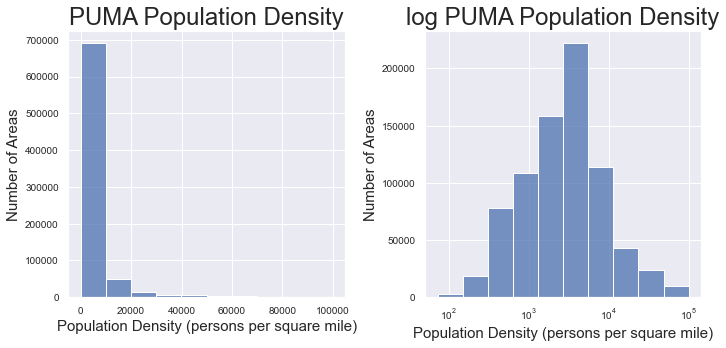

In [27]:
# Figure 1

plt.subplot(1, 2, 1)
sns.histplot(data = df, x = 'density', bins = 10)
plt.title('PUMA Population Density')
plt.ylabel('Number of Areas')
plt.xlabel('Population Density (persons per square mile)')

plt.subplot(1, 2, 2)
sns.histplot(data = df, x = 'density', log_scale = True, bins = 10)
plt.title('log PUMA Population Density')
plt.ylabel('Number of Areas')
plt.xlabel('Population Density (persons per square mile)')

plt.tight_layout()

In [28]:
# Variable 1

df['l_density'] = np.log10(df['density'])
df = df.drop(columns = 'density')

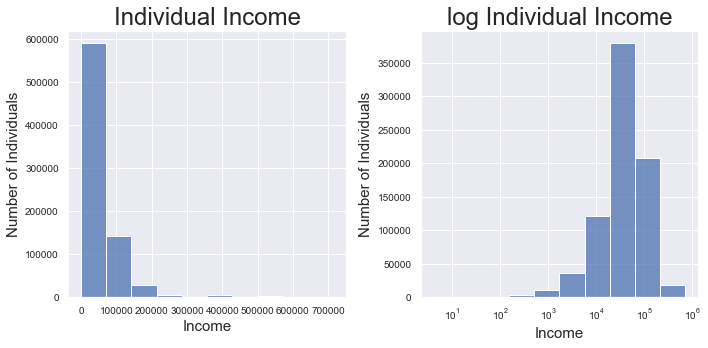

In [29]:
# Figure 2

plt.subplot(1, 2, 1)
sns.histplot(data = df, x = 'incwage', bins = 10)
plt.title('Individual Income')
plt.ylabel('Number of Individuals')
plt.xlabel('Income')

plt.subplot(1, 2, 2)
sns.histplot(data = df, x = 'incwage', log_scale = True, bins = 10)
plt.title('log Individual Income')
plt.ylabel('Number of Individuals')
plt.xlabel('Income')

plt.tight_layout()

In [30]:
# Variable 2

df['l_incwage'] = np.log10(df['incwage'])
df = df.drop(columns = 'incwage')

* **[1 point]** reorder the variables matching the `acs` selection above with the transformed variables
    - Order: keys, labels, continuous features, discrete features
    - `hpi` wink, wink

In [31]:
df = df[['county', 'full_time', 'degree', 'l_incwage', 'puma_urate', 'occ_ba', 'ind_wage', 'hpi', 'l_density', 
         'experience', 'any_kids', 'female', 'black', 'hispanic', 'occ2010', 'ind1990']]

*********
# [5 Points] Pickling
[TOP](#Homework-1---Yeehaw!-Data-Wrangling!)

* **[2 point]** First, print the head of your data frame.

In [32]:
df.head()

,county,full_time,degree,l_incwage,puma_urate,occ_ba,ind_wage,hpi,l_density,experience,any_kids,female,black,hispanic,occ2010,ind1990
id,,,,,,,,,,,,,,,,
14401,1003,1,ba or more,4.330414,2.655123,47.754789,52873.612161,138.88,2.399154,2,0,1,0,0,4850,542
17301,1003,1,some college,4.845098,2.655123,15.251667,65637.668547,138.88,2.399154,29,1,0,0,0,7020,441
18501,1003,1,ba or more,4.892095,2.655123,24.793268,16368.306561,138.88,2.399154,31,0,1,0,0,310,641
26701,1003,1,hs or less,3.892095,2.655123,40.414456,47867.063406,138.88,2.399154,36,1,0,0,0,3710,901
37101,1003,0,some college,4.380211,2.655123,21.519082,40205.435206,138.88,2.399154,43,0,1,0,0,3410,642


* **[3 points]** Save the final data frame to a pickle with a fancy name like "hw_data.pkl"

In [33]:
df.to_pickle('hw_data.pkl')